## 1. Packages & Parallel Processing Setup

In [ ]:
# Initialize Distributed Workers
using Distributed
if nworkers() == 1
    addprocs(10)  # PARAM - adjust number of workers as needed i.e. available CPU cores
end
using ProgressMeter
using Plots
@everywhere begin
    using Agents
    using Distributions
    using Random
end

## 2. Agent definition

In [27]:
@everywhere begin
    # Define Player (0 = defector, 1 = cooperator)
    @agent struct Player(GridAgent{2})
        old_stratagy::Int64
        stratagy::Int64
        payoff::Float64
    end
end

## 3. Model initialization

In [28]:
@everywhere begin
    # M is the grid size, 
    # init_coop_freq is the initial fraction of cooperators,
    # b is the benefit, c is the cost, and symm determines if copying is done synchronously or asynchronously.
    function initialize(; M=10, init_coop_freq=0.5, b=0.47, c=0.25, prob=0.0, symm=false)

        gridsize = (M, M)
        space = GridSpaceSingle(gridsize; periodic=true, metric=:manhattan)


        properties = Dict(
            :payoff_benefit => b,
            :payoff_cost => c,
            :init_coop_freq => init_coop_freq,
            :symm => symm,
            :prob => prob
        )


        model = StandardABM(
            Player, space;
            agent_step!,
            model_step!,
            properties=properties,
            scheduler=Schedulers.Randomly()
        )

        # Calculate how many cooperators and defectors to place initially
        num_coop = round(Int, M^2 * init_coop_freq)
        num_def = M^2 - num_coop

        strategies = vcat(ones(Int, num_coop), zeros(Int, num_def)) 

        shuffle!(strategies)

        for s in strategies
            add_agent_single!(model; old_stratagy=s, stratagy=s, payoff=0.0)
        end

        return model
    end
end

## 4. Dynamics - agent_step! (swap places)

In [29]:
@everywhere begin
    function agent_step!(a, model)
        if rand() < model.prob # agents move to prevent assortment with probability prob
            b = random_agent(model) 
            while b.id == a.id
                b = random_agent(model)
            end
            swap_agents!(a, b, model) # swap positions of two agents 
        end
        return
    end
end


## 5. Dynamics - model_step! (payoff & update strategy)

In [30]:
@everywhere begin
    function model_step!(model)

        agents = collect(allagents(model))
        shuffle!(agents)
        for a in agents
            a.old_stratagy = a.stratagy
        end

        for a in agents # Calculate payoffs 
            n_coop = 0
            n_total = 0
            for n in nearby_agents(a, model, 1) # Count cooperators     
                n_total += 1
                n_coop += (n.stratagy == 1) ? 1 : 0
            end
            n_def = n_total - n_coop

            if a.stratagy == 1 # payoff for cooperators
                a.payoff = n_coop * (model.payoff_benefit - model.payoff_cost) - n_def * model.payoff_cost
            else # payoff for defectors
                a.payoff = n_coop * model.payoff_benefit
            end
        end

        if model.symm # Synchronous update: all agents copy the best neighbor's old strategy
            for a in agents
                nbs = collect(nearby_agents(a, model, 1))
                maxp = maximum(n.payoff for n in nbs) # Find the maximum payoff among neighbors
                if maxp > a.payoff # If the best neighbor's payoff is better than the agent's payoff, copy.
                    candidates = [n for n in nbs if n.payoff == maxp] # If multiple neighbors have the same max payoff, randomly select one to copy.
                    best = rand(candidates)
                    a.stratagy = best.old_stratagy
                end
            end
        else # Asynchronous update: all agents copy the best neighbor's current strategy
            for a in agents
                nbs = collect(nearby_agents(a, model, 1))
                maxp = maximum(n.payoff for n in nbs) # Find the maximum payoff among neighbors
                if maxp > a.payoff # If the best neighbor's payoff is better than the agent's payoff, copy.
                    candidates = [n for n in nbs if n.payoff == maxp]
                    best = rand(candidates)
                    a.stratagy = best.stratagy
                end
            end
        end

        return
    end
end


## 6. Helper- strategies on grid 

In [31]:
@everywhere begin
    # returns a grid of agent strategies
    function get_strategy_grid(model)
        grid = zeros(Int, spacesize(model)[1], spacesize(model)[2])
        for a in allagents(model)
            grid[a.pos...] = a.stratagy
        end
        return grid
    end
end


## 7.  Helper- running simulation batches

In [32]:

@everywhere begin
    # run the model until equilibrium or max_steps
    function rununtil(model; max_steps=200)
        step = 0
        while step < max_steps
            step!(model, 1)
            stable = true
            for a in allagents(model)
                if a.old_stratagy != a.stratagy
                    stable = false
                    break
                end
            end
            stable && break
            step += 1
        end
        return step
    end

    function run_trial(; M=50, init_coop_freq=0.5, symm=true, b=1.0, c=0.25, prob=0.0)
        model = initialize(M=M, init_coop_freq=init_coop_freq, symm=symm, b=b, c=c, prob=prob)

        steps = rununtil(model)
        final_coop_frac = mean(a -> a.stratagy == 1, allagents(model))

        return (steps, final_coop_frac)
    end

    # run multiple trials and store results
    function run_trials(; n_trials=100, M=50, init_coop_freq=0.5, symm=true, b=1.0, c=0.25, prob=0.0)
        steps_arr = zeros(n_trials)
        coop_frac_arr = zeros(n_trials)

        for trial in 1:n_trials
            steps, final_coop_frac =
                run_trial(M=M, init_coop_freq=init_coop_freq, symm=symm, b=b, c=c, prob=prob)
            steps_arr[trial] = steps
            coop_frac_arr[trial] = final_coop_frac
        end

        return (
            steps_arr=steps_arr,
            coop_frac_arr=coop_frac_arr,
            steps_mean=mean(steps_arr),
            coop_frac_mean=mean(coop_frac_arr)
        )
    end
end


## 8. Simulate 

In [33]:
# set parameters: fixed cost, sweep over prob
prob_range = 0:0.005:0.1
symm_range = [false, true]

param_combos = [(pb, s, "pb = $(pb), symm = $(s)") for pb in prob_range for s in symm_range]
results_dict = Dict()
# set up progress meter
p = Progress(length(param_combos), dt=0.1, desc="Running batch experiments")
progress_channel = RemoteChannel(() -> Channel{Int}(1000))

@async begin
    for _ in progress_channel
        next!(p)
    end
end


# run simulations
results_tuples = pmap(x -> begin
        pb, s, label = x
        res = run_trials(n_trials=100, M=30, init_coop_freq=0.5,
            symm=s, b=1.0, c=0.2, prob=pb)
        remotecall_fetch(() -> put!(progress_channel, 1), 1)
        (label, res)
    end, param_combos)

for (label, run_res) in results_tuples
    results_dict[label] = run_res
end


Running batch experiments 100%|██████████████████████████| Time: 0:00:29


## 9. Helper- build plot

In [54]:
# Plot how final cooperator frequency changes with probability 
# comparing synchronous vs asynchronous updates
function plot_coop_frequency_vs_prob(results_dict)
    # collect unique pb values from keys like "pb = 0.05, symm = true" 
    pb_values = sort(unique([parse(Float64, match(r"pb = ([\d\.]+)", k).captures[1]) for k in keys(results_dict)]))

    mean_freq_true = Float64[]
    mean_freq_false = Float64[]

    scatter_x_true, scatter_y_true = Float64[], Float64[]
    scatter_x_false, scatter_y_false = Float64[], Float64[]

    for pb in pb_values
        all_freqs_true = Float64[]
        all_freqs_false = Float64[]

        for symm in (true, false)
            param_label = "pb = $(pb), symm = $(symm)"
            freq_list = results_dict[param_label].coop_frac_arr
            if symm
                append!(all_freqs_true, freq_list)
                append!(scatter_x_true, fill(pb, length(freq_list)))
                append!(scatter_y_true, freq_list)
            else
                append!(all_freqs_false, freq_list)
                append!(scatter_x_false, fill(pb, length(freq_list)))
                append!(scatter_y_false, freq_list)
            end
        end

        push!(mean_freq_true, isempty(all_freqs_true) ? NaN : mean(all_freqs_true))
        push!(mean_freq_false, isempty(all_freqs_false) ? NaN : mean(all_freqs_false))
    end

    plt = scatter(scatter_x_true, scatter_y_true;
        xlabel="Probability", ylabel="Cooperator Frequency",
        label=:none, markercolor=:blue, marker=:diamond, alpha=0.4, markersize=3, dpi=300, fmt=:png)

    scatter!(plt, scatter_x_false, scatter_y_false;
        label=:none, markercolor=:red, alpha=0.4, markersize=3)

    plot!(plt, pb_values, mean_freq_true;
        linewidth=2, marker=:diamond, color=:blue, label="Mean Synchronous")

    plot!(plt, pb_values, mean_freq_false;
        linewidth=2, marker=:circle, color=:red, label="Mean Asynchronous")

    return plt
end


plot_coop_frequency_vs_prob (generic function with 1 method)

## 10. Display plot

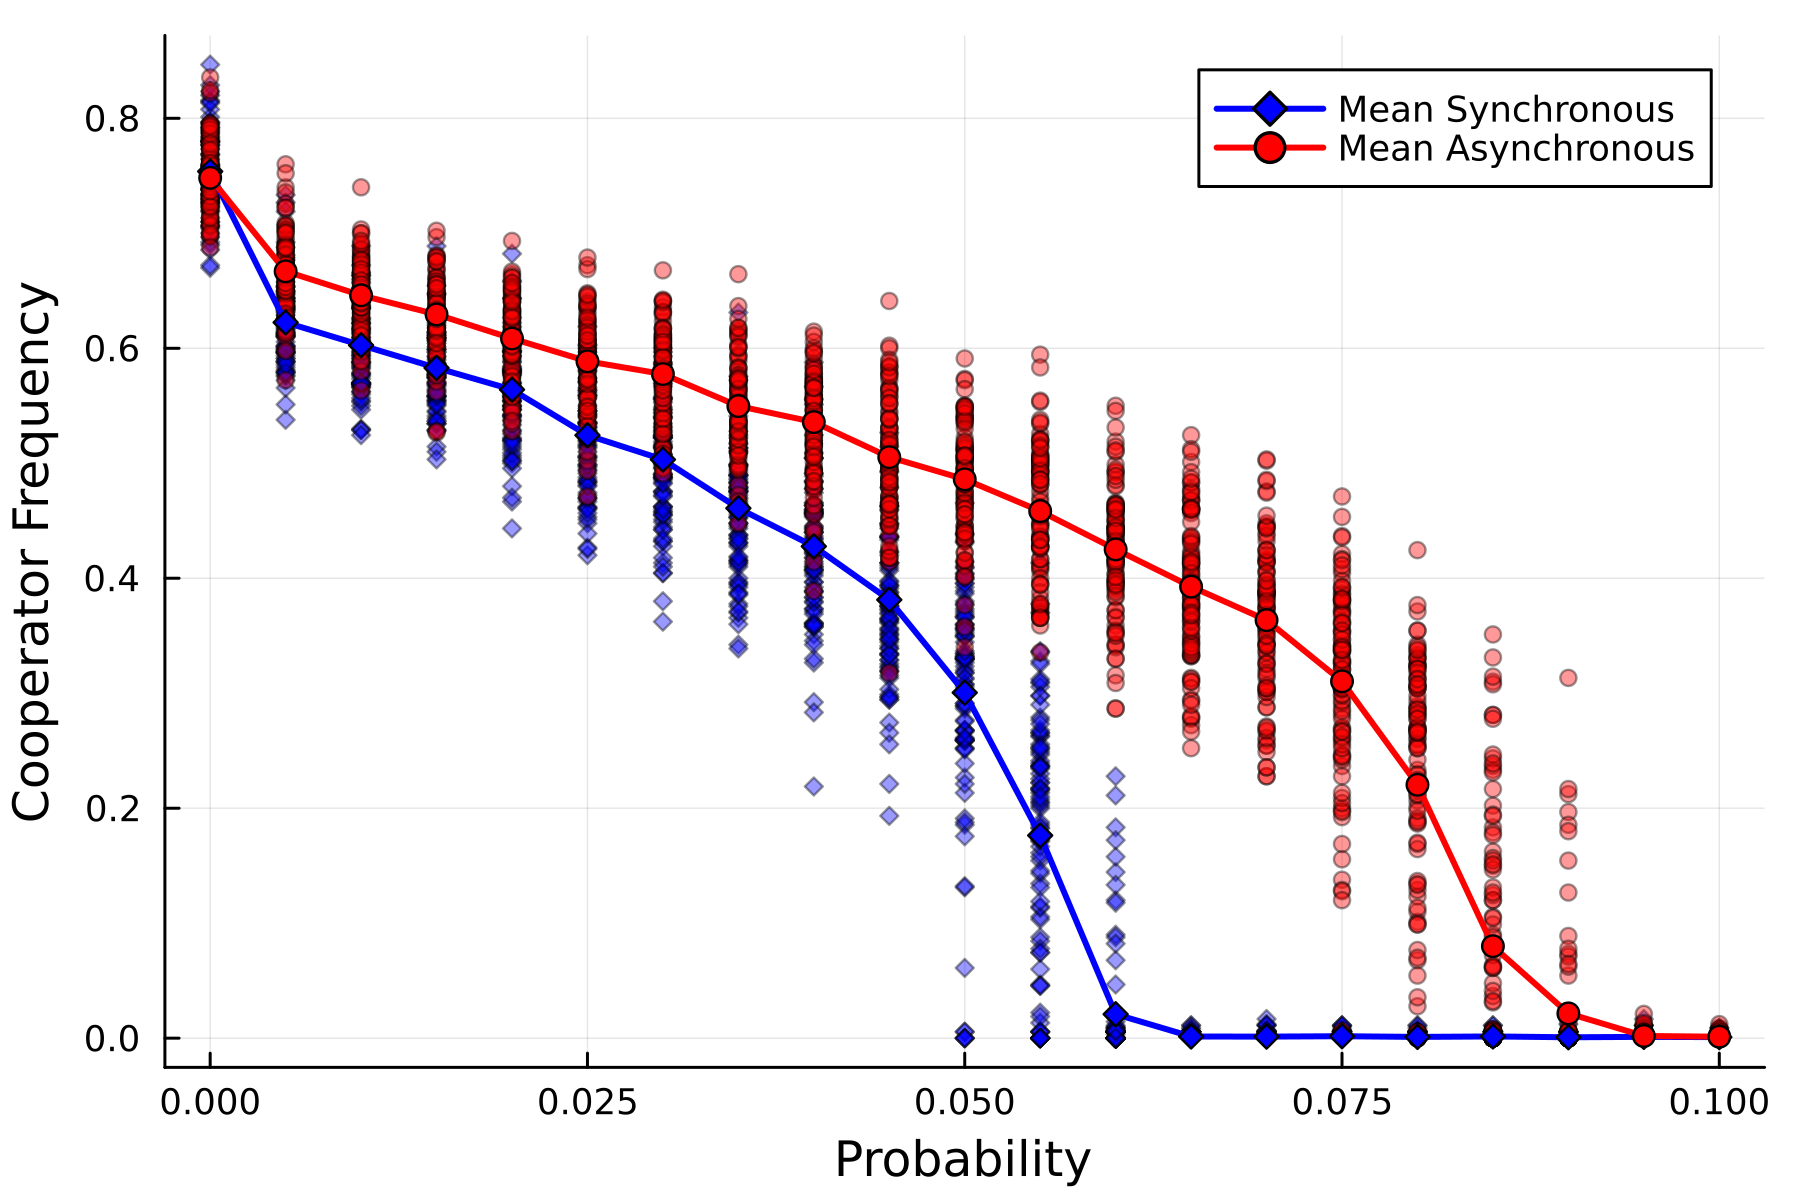

In [55]:
# Plot probability vs cooperator frequency
plot_coop_frequency_vs_prob(results_dict)